### 0. Tutorials
https://medium.com/data-scientists-playground/lstm-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E8%82%A1%E5%83%B9%E9%A0%90%E6%B8%AC-cd72af64413a

#### bidirectional 雙向
![](https://i.imgur.com/XKaKiVp.png)

#### num_layers
![](https://i.imgur.com/WVdo5fZ.png)

#### input (batch , time step , hidden layer)
- 以下範例為 time_step=2 hidden_layer=5
- word2vec後
    - 第一句 [0 , 0 , 1, 1 ,0]
    - 第二句 [1 , 1 , 1, 0 ,0]
- time_step =　句子數量　ｏｒ　時序性資料筆數
- hidden layer = LSTM cell 內部的unit數　=　500　
- hidden layer = word to vector 後的向量維度
    
![](https://i.imgur.com/rpsEHfj.png)

### 1. Module

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2. Hypermeters 

In [4]:
num_epochs = 10
batch_size = 64

TIME_STEP = 28        # rnn time step, 即图片的高
INPUT_SIZE = 28       # rnn input size, 即图片的宽
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_CLASSES = 10
BIDIRECTIONAL = True  # 是否开启双向

learning_rate = 0.01

### 3. Load Data

In [5]:
train_data = dsets.MNIST(root='./mnist/' ,train=True ,transform=transforms.ToTensor() ,download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])
torch.Size([60000])


/opt/conda/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


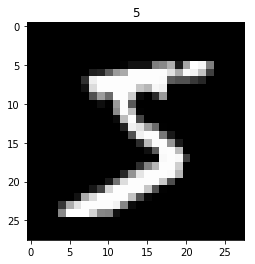

In [6]:
# 看一下数据
print(train_data.train_data.size())    # (60000, 28, 28)
print(train_data.targets.size())  # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [7]:
test_data = dsets.MNIST(root='./mnist/' ,train=False ,transform=transforms.ToTensor())
test_x = Variable(test_data.test_data).type(torch.FloatTensor)[:2000] / 255.
test_y = test_data.targets[:2000].data.numpy()

/opt/conda/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [8]:
print("Cuda State :",torch.cuda.is_available())
if torch.cuda.is_available():
    test_x = test_x.view(-1, 28, 28).to(device)

Cuda State : True


### 4. LSTM Module

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional):
        super(RNN, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers=num_layers,
            batch_first = True, # 第一个维度设为 batch, 即:(batch, time_step, input_size)
            bidirectional=bidirectional  # 是否用双向 (True/False)
        )
        self.out = nn.Linear(hidden_size*2 ,num_classes) if bidirectional else nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x: (batch, time_step, input_size)
        # r_out: (batch, time_step, output_size)
        # h_n: (n_layers, batch, hidden_size)
        # h_c: (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)  # None即隐层状态用0初始化
                
        # 我们只需要最后一步的输出, 即(batch, -1, output_size)
        out = self.out(r_out[:, -1, :])
        
        return out   

In [10]:
rnn = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    bidirectional=BIDIRECTIONAL
)
print(rnn)

if torch.cuda.is_available():
    rnn = rnn.cuda()

RNN(
  (rnn): LSTM(28, 64, num_layers=2, batch_first=True, bidirectional=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

### 5. Training

In [12]:
for epoch in range (num_epochs):
    for step, (x,y) in enumerate(train_loader): #batch_size (iteration)
        b_x =  b_x = x.view(-1, 28, 28).to(device)
        b_y = y.to(device)
        
         # Clear all accumulated gradients
        optimizer.zero_grad()
        output = rnn(b_x)
        loss = loss_func(output, b_y) # Compute the loss based on the predictions and actual labels
        loss.backward() # Backpropagate the loss
        
        optimizer.step()  # Adjust parameters according to the computed gradients
        
    test_output = rnn(test_x)
    pred_y = torch.max(test_output, dim=1)[1].data.cpu().numpy().squeeze()
    accuracy = sum(pred_y == test_y) / len(test_y)
    print('epoch: ', epoch, '| train loss: %.4f' % loss,'| test accuracy: %.2f' % accuracy)


epoch:  0 | train loss: 0.0296 | test accuracy: 0.96
epoch:  1 | train loss: 0.0939 | test accuracy: 0.96
epoch:  2 | train loss: 0.0402 | test accuracy: 0.97
epoch:  3 | train loss: 0.3785 | test accuracy: 0.97
epoch:  4 | train loss: 0.0245 | test accuracy: 0.97
epoch:  5 | train loss: 0.2366 | test accuracy: 0.97
epoch:  6 | train loss: 0.0168 | test accuracy: 0.96
epoch:  7 | train loss: 0.2185 | test accuracy: 0.97
epoch:  8 | train loss: 0.3539 | test accuracy: 0.97
epoch:  9 | train loss: 0.0992 | test accuracy: 0.97


In [13]:
# 看一下10个结果
test_output = rnn(test_x.view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
acc = sum(pred_y == test_y) / len(test_y)

print("LSTM Mnist Accuracy :",acc)


LSTM Mnist Accuracy : 0.9685
